In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

### Merging evaluation systems results

In [33]:
statistics_path = os.path.join(os.sep, "home", "data")

query_statistics_output_file  = os.path.join(statistics_path, "query_statistics.csv")
ingestion_statistics_output_file = os.path.join(statistics_path, "ingestion_statistics.csv")

figures_path = os.path.join(os.sep, "home", "figures")

In [34]:
def add_iteration_column(df: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    """
    Groupby su group_cols e aggiunge una colonna 'iteration'
    con un contatore cumulativo 0..n-1 per ogni gruppo.
    """
    df = df.copy()
    df["iteration"] = df.groupby(group_cols).cumcount()
    return df

In [ ]:
# Delete old statistics
# os.remove(query_statistics_output_file)
# os.remove(ingestion_statistics_output_file)

ingestion_statistics = pd.DataFrame()
query_statistics = pd.DataFrame()

# Aggregate different systems results

for evaluated_system in os.listdir(statistics_path):
    if os.path.isdir(os.path.join(statistics_path, evaluated_system)):
        ingestion_file = os.path.join(statistics_path, evaluated_system, "ingestion_time","ingestion_statistics.csv")
        query_file = os.path.join(statistics_path, evaluated_system, "query_evaluation","statistics.csv")
        # query = pd.read_csv(query_file)
        # query.drop(columns=["iteration"], inplace=True)
        # query["temporalRangeIndex"] = 0
        # if (query["model"] == "STGraph").all():
        #     query = add_iteration_column(query, ["model","dataset","datasetSize","queryName","threads","queryType","querySelectivity","numMachines"])
        # else:
        #     query = add_iteration_column(query, ["test_id","model","dataset","datasetSize","threads","queryName","queryType","querySelectivity","numMachines"])
        # query.to_csv(query_file, index=False)
        ingestion_statistics = pd.concat([ingestion_statistics, pd.read_csv(ingestion_file)], ignore_index=True)
        query_statistics = pd.concat([query_statistics, pd.read_csv(query_file)], ignore_index=True)

ingestion_statistics["datasetSize"] = ingestion_statistics["datasetSize"].apply(lambda x: str.capitalize(x))
query_statistics["datasetSize"] = query_statistics["datasetSize"].apply(lambda x: str.capitalize(x))

ingestion_statistics.to_csv(ingestion_statistics_output_file, index=False )
query_statistics.to_csv(query_statistics_output_file, index=False )

Utils

In [25]:
query_names = {
    "EnvironmentCoverage": "Q1",
    "EnvironmentAggregate": "Q2",
    "MaintenanceOwners": "Q3",
    "EnvironmentAlert": "Q4",
    "AgentOutlier": "Q5",
    "AgentHistory": "Q6"
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
patterns = ['solid', '...', '///']              # hatch patterns for consistency

## Generating figures

Ingestion statistics

/tmp/ipykernel_722/3613480354.py:49: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  bar = ax.bar(
/tmp/ipykernel_722/3613480354.py:95: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor=colors[i], hatch=patterns[i], edgecolor='black', label=model)


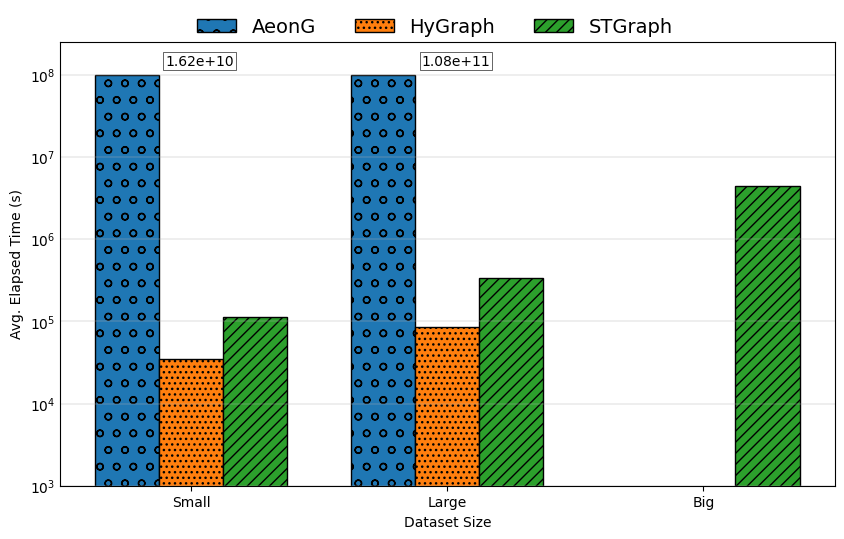

In [26]:

# Copy the dataframe
df = ingestion_statistics.copy(deep=True)

# Filter for threads = 1
df = df[df["threads"] == 1]

# Compute the mean of elapsedTime for Dataset Size and Model
grouped = (
    df.groupby(["datasetSize", "model"])["elapsedTime"]
    .mean()
    .reset_index()
)

# Order of datasetSize as in Tableau
dataset_order = ["Small", "Large", "Big"]
grouped["datasetSize"] = pd.Categorical(grouped["datasetSize"], categories=dataset_order, ordered=True)

# Plot parameters
all_models = sorted(grouped["model"].unique())
bar_width = 0.25
x = np.arange(len(dataset_order))

# Colors and patterns (keep your existing ones)
# Ensure colors, patterns exist in your session!
# colors = [...]
# patterns = [...]

fig, ax = plt.subplots(figsize=(10, 6))

CLIP_VALUE = 1e8  # threshold where bars get clipped

# Draw bars for each model
for i, model in enumerate(all_models):
    for j, ds in enumerate(dataset_order):

        subset = grouped[
            (grouped["datasetSize"] == ds) &
            (grouped["model"] == model)
        ]

        if subset.empty:
            value = np.nan
        else:
            value = subset["elapsedTime"].values[0]

        # Clip bar height at 1e8
        display_value = min(value, CLIP_VALUE)

        bar = ax.bar(
            x[j] + i * bar_width,
            display_value,
            width=bar_width,
            color=colors[i % len(colors)],
            edgecolor='black',
            hatch=patterns[i % len(patterns)],
            label=model if j == 0 else None
        )

        # Add label for clipped bars (to the right of bar)
        if value > CLIP_VALUE:
            ax.text(
                x[j] + i * bar_width + bar_width * 0.60,
                CLIP_VALUE * 1.20,
                f"{value:.2e}",
                va='bottom',
                ha='left',
                fontsize=10,
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    linewidth=0.5,
                    alpha=0.85,
                    pad=1.5
                )
            )
# X axis
ax.set_xticks(x + bar_width)
ax.set_xticklabels(dataset_order)
ax.set_xlabel("Dataset Size")

# Y axis (log scale + fixed limits)
ax.set_yscale("log")
ax.set_ylim(1e3, 10**8.4)  # gives margin above 1e8

ax.set_ylabel("Avg. Elapsed Time (s)")

# Remove tick lines but keep labels
ax.tick_params(axis='y', which='both', length=0)

# Grid
ax.grid(True, which="major", axis="y", linewidth=0.3)

# Create legend handles
handles = [
    mpatches.Patch(facecolor=colors[i], hatch=patterns[i], edgecolor='black', label=model)
    for i, model in enumerate(all_models)
]

# Single legend above all subplots
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=len(all_models),
    frameon=False,
    bbox_to_anchor=(0.5, 0.92),
    fontsize=14
)

# Space for the legend
plt.subplots_adjust(top=0.85, wspace=0.3)

plt.savefig(os.path.join(figures_path,"ingestion_statistics.svg"), format='svg', bbox_inches='tight')
plt.show()

Query statistics

/tmp/ipykernel_722/348094058.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/348094058.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/348094058.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/348094058.py:71: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 

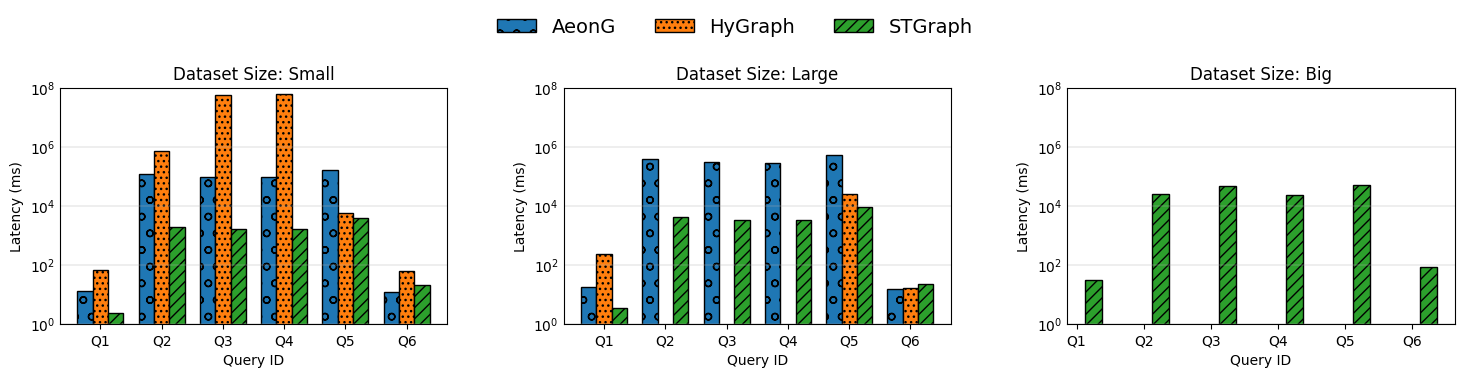

In [27]:
query_df = query_statistics.copy(deep=True)
query_df = query_df.loc[query_df["datasetSize"] != "big_long"]

query_df["queryID"] = query_df["queryName"].apply(lambda row: query_names[row])

# List of unique dataset sizes
dataset_sizes = ["Small", "Large", "Big"]

# Create figure with a subplot for each dataset size
fig, axes = plt.subplots(1, len(dataset_sizes), figsize=(6 * len(dataset_sizes), 4))  # removed sharey=True

# If there's only one datasetSize, axes is not a list
if len(dataset_sizes) == 1:
    axes = [axes]

# Plot parameters
bar_width = 0.25
all_models = sorted(query_df["model"].unique())

for ax, ds in zip(axes, dataset_sizes):
    # Filter for datasetSize and threads=1
    df_filtered = query_df[(query_df["threads"] == 1) & (query_df["datasetSize"] == ds)]

    # Group by queryID and model
    grouped = (
        df_filtered.groupby(["queryID", "model"])["elapsedTime"]
        .mean()
        .reset_index()
    )

    query_ids = grouped["queryID"].unique()
    models = grouped["model"].unique()
    x = np.arange(len(query_ids))

    # Draw bars
    for i, model in enumerate(all_models):
        values = [
            grouped[(grouped["queryID"] == q) & (grouped["model"] == model)]["elapsedTime"].values[0]
            if not grouped[(grouped["queryID"] == q) & (grouped["model"] == model)].empty
            else np.nan
            for q in query_ids
        ]
        ax.bar(
            x + i * bar_width,
            values,
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            hatch=patterns[i]
        )

    # X axis
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(query_ids)
    ax.set_xlabel("Query ID")

    ax.tick_params(axis='y', which='both', length=0)  # length=0 hides the tick lines
    # Y axis
    ax.set_yscale("log")
    ax.set_ylim(1, 1e8)
    ax.set_ylabel("Latency (ms)")

    # Subplot title
    ax.set_title(f"Dataset Size: {ds.capitalize()}")

    # Grid
    ax.grid(True, which="both", axis="y", linewidth=0.3)

# Create legend handles
handles = [
    mpatches.Patch(facecolor=colors[i], hatch=patterns[i], edgecolor='black', label=model)
    for i, model in enumerate(all_models)
]

# Single legend above all subplots
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=len(all_models),
    frameon=False,
    bbox_to_anchor=(0.5, 0.92),  # closer to the plots
    fontsize=14                # larger text
)


# Space for the legend
plt.subplots_adjust(top=0.7, wspace=0.3)  # lower top to bring the legend closer
plt.savefig(os.path.join(figures_path,"query_statistics.svg"), format='svg', bbox_inches='tight')
plt.show()


### STGraph - Scale Out

Ingestion stats

   numMachines  graphElapsedTime  tsElapsedTime
0            2      83512.600000   1.038752e+07
1            4     109115.862745   5.559638e+06
2            8     134872.454545   3.425224e+06


/tmp/ipykernel_722/2101256888.py:37: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/2101256888.py:65: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],


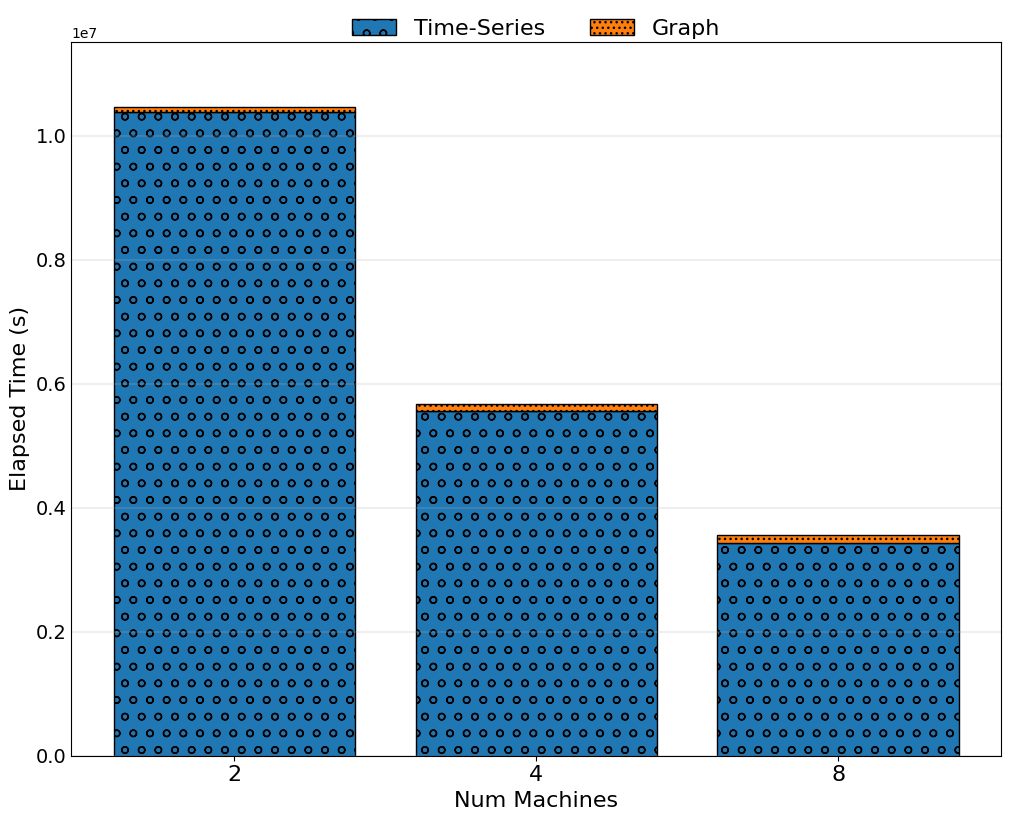

In [28]:
def plot_stacked_elapsed_times(df, model_filter, threads_filter, dataset_filter):  
    """  
    Build a stacked bar chart similar to the Tableau screenshot, using a consistent style.  

    Parameters:  
    - df: pandas DataFrame containing columns:  
        ['model', 'threads', 'datasetSize', 'numMachines', 'graphElapsedTime', 'tsElapsedTime']  
    - model_filter: str, e.g. 'STGraph'  
    - threads_filter: int, e.g. 1  
    - dataset_filter: str, e.g. 'big_long'  
    - unit: 'ms', 's', or 'min' (default 'ms')  
    """  


    # Filter data according to model, threads, and dataset size  
    filtered = df[  
        (df["model"] == model_filter) &  
        (df["threads"] == threads_filter) &  
        (df["datasetSize"] == dataset_filter)  
    ]  

    # Group by number of machines and compute the mean elapsed times  
    grouped = filtered.groupby("numMachines")[["graphElapsedTime", "tsElapsedTime"]].mean().reset_index()  
    grouped = grouped.sort_values("numMachines")  

    print(grouped)

    # Discrete x positions for compact bars  
    x = np.arange(len(grouped))  

    # Create figure and axes  
    fig, ax = plt.subplots(figsize=(12, 6))  

    # Draw stacked bars  
    bottom = np.zeros(len(grouped))  
    for i, col in enumerate(["tsElapsedTime", "graphElapsedTime"]):  
        ax.bar(  
            x,  
            grouped[col],  
            bottom=bottom,  
            color=colors[i],  
            edgecolor='black',  
            hatch=patterns[i],  
            label=col.replace("ElapsedTime", " Latency")
        )
        bottom += grouped[col].values

    # Set X-axis labels only for actual number of machines
    ax.set_xticks(x)
    ax.set_xticklabels(grouped["numMachines"], fontsize=16)
    ax.set_xlabel("Num Machines", fontsize=16)

    # ax.set_yscale("log")

    # Y-axis – linear scale with extra space above maximum
    ax.set_ylabel(f"Elapsed Time (s)", fontsize=16)
    ax.set_ylim(0, bottom.max() * 1.1)
    ax.tick_params(axis='y', which='both', length=0,labelsize=14,)  # remove tick lines

    # Horizontal grid lines for reference
    ax.grid(True, axis="y", linewidth=0.3)

    # Custom legend for stacked bars
    handles = [
        mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],
                       label=col.replace("ElapsedTime", " Latency"))
        for i, col in enumerate(["Time-Series", "Graph"])
    ]
    ax.legend(handles=handles, loc='upper center', ncol=2, frameon=False,
              bbox_to_anchor=(0.5, 1.06), fontsize=16)

    # Adjust layout and save figure as SVG
    plt.subplots_adjust(top=1.3, wspace=0.3)
    plt.savefig(os.path.join(figures_path, f"scaleout_ingestion_statistics.svg"), format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage:
plot_stacked_elapsed_times(ingestion_statistics.loc[ingestion_statistics["numMachines"] > 1], "STGraph", 16, "Big_long")


Query Latency

2 machines -> [np.float64(45648.76666666667), np.float64(9506.833333333334), np.float64(293696.1666666667), np.float64(47680.8)]
4 machines -> [np.float64(28419.166666666668), np.float64(10230.016666666666), np.float64(167119.61666666667), np.float64(29613.25)]
8 machines -> [np.float64(17918.866666666665), np.float64(11416.733333333334), np.float64(80083.46666666666), np.float64(20084.633333333335)]


/tmp/ipykernel_722/3686497003.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(


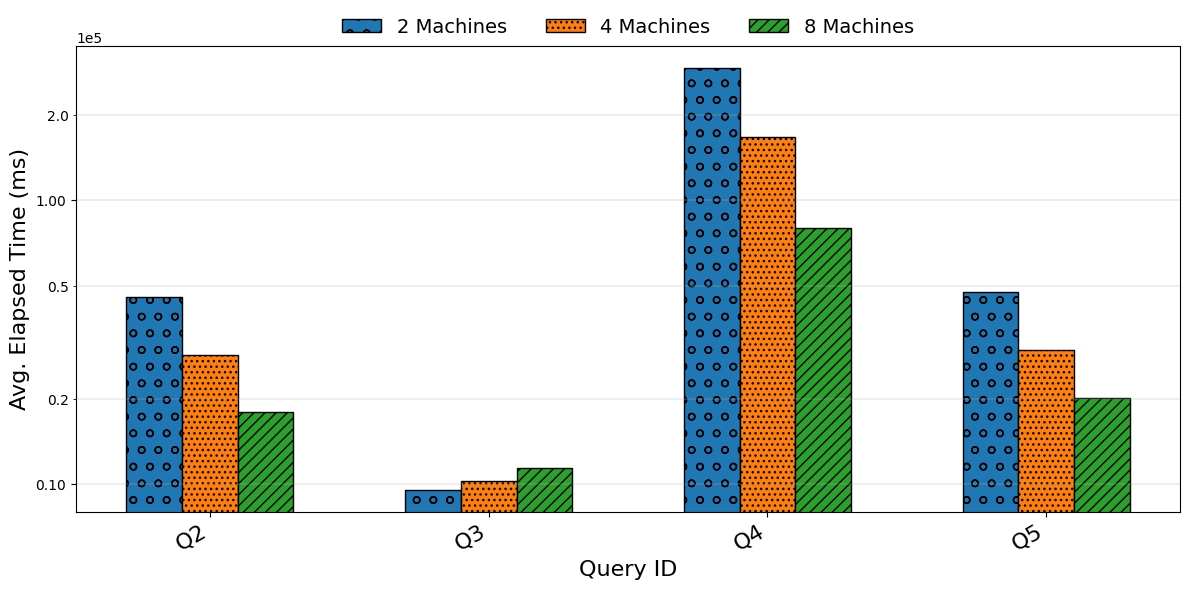

In [31]:
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter

# Copy dataframe
df = query_statistics.copy(deep=True)
df = df.loc[(query_statistics["queryName"] != "AgentHistory") & (query_statistics["queryName"] != "EnvironmentCoverage")]
df["queryID"] = df["queryName"].apply(lambda row: query_names[row])
# Filter as in Tableau dashboard
df = df[
    (df["threads"] == 16) &
    (df["datasetSize"] == "Big_long") &
    (df["model"] == "STGraph")
]

# Compute mean elapsed time grouped by Query Name and Num Machines
grouped = (
    df.groupby(["queryID", "numMachines"])["elapsedTime"]
    .mean()
    .reset_index()
)

# Sort query names consistently
query_names_sorted = sorted(grouped["queryID"].unique())

# Sort numMachines as numeric order (2,4,8,...)
machines_sorted = sorted(grouped["numMachines"].unique())

# X positions
x = np.arange(len(query_names_sorted))
bar_width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))

# Draw bars
for i, m in enumerate(machines_sorted):
    # Values for each query
    values = [
        grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)]["elapsedTime"].values[0]
        if not grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)].empty
        else np.nan
        for q in query_names_sorted
    ]
    print(f"{m} machines ->", list(values))
    ax.bar(
        x + i * bar_width,
        values,
        width=bar_width,
        color=colors[i % len(colors)],
        edgecolor='black',
        hatch=patterns[i % len(patterns)],
        label=f"{m} Machines"
    )

# X-axis
ax.set_xticks(x + bar_width * (len(machines_sorted)-1) / 2)
ax.set_xticklabels(query_names_sorted, rotation=30, ha='right', fontsize=16)
ax.set_xlabel("Query ID", fontsize=16)

# Y-axis
ax.set_ylabel("Avg. Elapsed Time (ms)", fontsize=16)
ax.set_yscale("log")

# Major ticks = potenze di 10
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))

ax.yaxis.set_minor_locator(LogLocator(base=10.0,
                                      subs=[1,2,5],
                                      numticks=50))

sf = ScalarFormatter()
sf.set_scientific(True)        # forza notazione scientifica
sf.set_powerlimits((0,0))      # forza esponente per tutti i valori
ax.yaxis.set_major_formatter(sf)
ax.yaxis.set_minor_formatter(sf)

# Grid
ax.grid(True, which="both", axis="y", linewidth=0.3)

# Legend
ax.legend(
    loc="upper center",
    ncol=len(machines_sorted),
    frameon=False,
    fontsize=14,
    bbox_to_anchor=(0.5, 1.10)
)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "scaleout_query_statistics.svg"), format='svg', bbox_inches='tight')
plt.show()